# Librerías

In [1]:
#!pip install wikipedia-api
#!pip install wordcloud
#!pip install -U spacy
#!python -m spacy download en_core_web_md
#!pip install -U gensim
#!pip install fuzzywuzzy
#!pip install python-Levenshtein

In [2]:
import numpy as np
import pandas as pd
import nltk
import re
import spacy
import en_core_web_md
import gensim
from gensim.models import KeyedVectors
from gensim.models.word2vec import Word2Vec
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import seaborn as sns
import string
import random
import wikipediaapi
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import sentiwordnet as swn
nltk.download('sentiwordnet')
import matplotlib.pyplot as plt
import pickle
import requests
from bs4 import BeautifulSoup

C:\Users\Ana\AppData\Local\Continuum\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\Ana\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


## ESLÓGANES

### Web scraping

In [3]:
# Conexión con la página web de la que se quieren extraer los eslóganes

page = requests.get("http://www.adglitz.com/blog/2010/07/ad-slogans-taglines-punchlines-500-slogans-from-famous-commercials-advertisements-adverts-all-time-great-database-of-ad-slogans")


# Obtención del código fuente

soup = BeautifulSoup(page.content, 'html.parser')

print(soup.prettify()[:500])

<!DOCTYPE html>
<html lang="en-US">
 <head>
  <meta charset="utf-8"/>
  <meta content="width=device-width, initial-scale=1, minimum-scale=1" name="viewport"/>
  <link href="http://gmpg.org/xfn/11" rel="profile"/>
  <link href="http://www.adglitz.com/xmlrpc.php" rel="pingback"/>
  <title>
   Ad slogans taglines punchlines. 500+ slogans from famous commercials advertisements adverts. All time great database of ad slogans – Adglitz
  </title>
  <link href="//s.w.org" rel="dns-prefetch">
   <link hr


In [4]:
# Selección de la información de interés (indicar la etiqueta que contiene la info)

allwithstrong = [j.get_text() for j in soup.find_all('span', style="color: black;")[2:]]

allwithstrong[:10]

['A-1 makes hamburgers taste like steakburgers',
 'Abbey National advertising slogans',
 'Get the Abbey habit',
 'Because life’s complicated enough',
 'advertising slogans',
 'Access takes the waiting out of wanting',
 'Makes sensible buying simple',
 'Access – Your Flexible Friend',
 'Does you does, or does you don’t take Access?',
 'Your flexible friend']

In [5]:
# Filtrar el nombre de la marca (contenida en la subetiqueta <strong>)

# Lista de los valores a eliminar

strongs = [i.get_text().replace(" ", "") for i in soup.find_all('strong')]

strongs[:10]

['advertisingslogans',
 '500commercialslogans,taglines,punchlinesandmarketingmottos.',
 'advertslogans,',
 'taglines,',
 'punchlines',
 'mottos',
 'sloganortagline',
 'A-1SteakSauceadvertisingtagline',
 'AbbeyNationaladvertisingslogans',
 'AccessCreditCardsloganadvertisingslogans']

In [6]:
# Selección de los eslóganes (exclusión de las marcas)

alls = [x for x in allwithstrong if x.replace(" ", "") not in strongs]

alls[:10]

['A-1 makes hamburgers taste like steakburgers',
 'Get the Abbey habit',
 'Because life’s complicated enough',
 'Access takes the waiting out of wanting',
 'Makes sensible buying simple',
 'Access – Your Flexible Friend',
 'Does you does, or does you don’t take Access?',
 'Your flexible friend',
 'The True Definition of Luxury. Yours.',
 'Fresh Squeezed Glaciers']

In [7]:
# Cantidad total de eslóganes

len(alls)

692

In [8]:
# Visualizar el contenido completo de todas las columnas

pd.set_option('display.max_colwidth', -1)

In [9]:
# Dataframe con los eslóganes extraídos mediande escrapeo

slogansDF = pd.DataFrame({"slogans": alls})

slogansDF.head()

,slogans
0,A-1 makes hamburgers taste like steakburgers
1,Get the Abbey habit
2,Because life’s complicated enough
3,Access takes the waiting out of wanting
4,Makes sensible buying simple


## ESQUELETOS

### Análisis morfológico

In [10]:
# Selección de los tags que deben aparecer en los esqueletos 

pos_in = ["CC", "CD", "DT", "EX", "IN", "MD", "PDT", "POS", "PRP", "PRP$", "RB", "RBR", "RBS", "RP", "UH", "TO", "WDT", "WP", "WP$", "WRB", "LS", ",", "."]

print(pos_in)

['CC', 'CD', 'DT', 'EX', 'IN', 'MD', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'UH', 'TO', 'WDT', 'WP', 'WP$', 'WRB', 'LS', ',', '.']


In [11]:
# Añadir una columna al dataframe inicial con el análisis POS_TAG de los eslóganes (división por palabras y transformación a minúsculas)

slogansDF['sloganTagged'] = slogansDF['slogans'].apply(lambda x: nltk.pos_tag(nltk.tokenize.word_tokenize(x.lower())))

slogansDF.head()

,slogans,sloganTagged
0,A-1 makes hamburgers taste like steakburgers,"[(a-1, JJ), (makes, VBZ), (hamburgers, NNS), (taste, VBP), (like, IN), (steakburgers, NNS)]"
1,Get the Abbey habit,"[(get, VB), (the, DT), (abbey, NN), (habit, NN)]"
2,Because life’s complicated enough,"[(because, IN), (life, NN), (’, NNP), (s, NN), (complicated, VBD), (enough, RB)]"
3,Access takes the waiting out of wanting,"[(access, NN), (takes, VBZ), (the, DT), (waiting, VBG), (out, IN), (of, IN), (wanting, VBG)]"
4,Makes sensible buying simple,"[(makes, VBZ), (sensible, JJ), (buying, NN), (simple, NN)]"


### Construcción de esqueletos

In [12]:
# Creo dos listas vacías

allSkeletons = []
allAuxis = []

# Recorro cada sloganTagged

for index,slogan in enumerate(slogansDF.sloganTagged):
    
    # Creo dos listas vacías (esqueletos y palabras auxiliares(keywords))
    
    skeleton = []
    
    auxi = []
    
    # Recorro cada palabra con su tag asociado 
    
    for pair in slogan:
        
        # Si el tag coincide con alguno de los acordados como parte de esqueleto, se añade la palabra a la lista de esqueleto
        
        if pair[1] in pos_in:
            
            skeleton.append(pair[0])
            
        # Si el tag no coincide con alguno de los acordados como parte de esqueleto, se añade el tag a la lista de auxis y a la lista de esqueletos
           
        else:
            
            skeleton.append(pair[1])
            auxi.append(pair[1])
            
    # Creamos una lista con todos los esqueletos y auxiliares generados por eslogan
    
    allSkeletons.append(skeleton)
    
    allAuxis.append(auxi)

# Añadimos dos columnas al datafreame inical (sloganSkeleton y sloganAuxi)

slogansDF['sloganSkeleton'] = allSkeletons

slogansDF['sloganAuxi'] = allAuxis

slogansDF.head()

,slogans,sloganTagged,sloganSkeleton,sloganAuxi
0,A-1 makes hamburgers taste like steakburgers,"[(a-1, JJ), (makes, VBZ), (hamburgers, NNS), (taste, VBP), (like, IN), (steakburgers, NNS)]","[JJ, VBZ, NNS, VBP, like, NNS]","[JJ, VBZ, NNS, VBP, NNS]"
1,Get the Abbey habit,"[(get, VB), (the, DT), (abbey, NN), (habit, NN)]","[VB, the, NN, NN]","[VB, NN, NN]"
2,Because life’s complicated enough,"[(because, IN), (life, NN), (’, NNP), (s, NN), (complicated, VBD), (enough, RB)]","[because, NN, NNP, NN, VBD, enough]","[NN, NNP, NN, VBD]"
3,Access takes the waiting out of wanting,"[(access, NN), (takes, VBZ), (the, DT), (waiting, VBG), (out, IN), (of, IN), (wanting, VBG)]","[NN, VBZ, the, VBG, out, of, VBG]","[NN, VBZ, VBG, VBG]"
4,Makes sensible buying simple,"[(makes, VBZ), (sensible, JJ), (buying, NN), (simple, NN)]","[VBZ, JJ, NN, NN]","[VBZ, JJ, NN, NN]"


In [13]:
# Eliminación de filas tras una exploración visual de los datos por inviabilidad de generar eslóganes correctos a partir de ellos

slogansDF = slogansDF[~slogansDF["slogans"].str.contains("Britvic")].reset_index(drop=True)

slogansDF = slogansDF[~slogansDF["slogans"].str.contains("Is it in you?")].reset_index(drop=True)

slogansDF = slogansDF[~slogansDF["slogans"].str.contains("Drink Camp - its the best")].reset_index(drop=True)

slogansDF = slogansDF[~slogansDF["slogans"].str.contains("night drink, 1960s")].reset_index(drop=True)

### Exploración de datos

In [14]:
# Añadir una columna con el conteo de las palabras auxiliares necesarias para formar el eslogan

slogansDF['auxiCount'] = [len(x) for x in slogansDF.sloganAuxi]
slogansDF.head()

,slogans,sloganTagged,sloganSkeleton,sloganAuxi,auxiCount
0,A-1 makes hamburgers taste like steakburgers,"[(a-1, JJ), (makes, VBZ), (hamburgers, NNS), (taste, VBP), (like, IN), (steakburgers, NNS)]","[JJ, VBZ, NNS, VBP, like, NNS]","[JJ, VBZ, NNS, VBP, NNS]",5
1,Get the Abbey habit,"[(get, VB), (the, DT), (abbey, NN), (habit, NN)]","[VB, the, NN, NN]","[VB, NN, NN]",3
2,Because life’s complicated enough,"[(because, IN), (life, NN), (’, NNP), (s, NN), (complicated, VBD), (enough, RB)]","[because, NN, NNP, NN, VBD, enough]","[NN, NNP, NN, VBD]",4
3,Access takes the waiting out of wanting,"[(access, NN), (takes, VBZ), (the, DT), (waiting, VBG), (out, IN), (of, IN), (wanting, VBG)]","[NN, VBZ, the, VBG, out, of, VBG]","[NN, VBZ, VBG, VBG]",4
4,Makes sensible buying simple,"[(makes, VBZ), (sensible, JJ), (buying, NN), (simple, NN)]","[VBZ, JJ, NN, NN]","[VBZ, JJ, NN, NN]",4


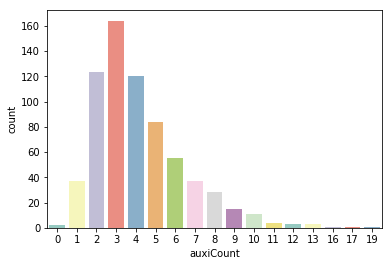

In [15]:
# Histograma de cantidad de palabras auxiliares por eslogan

auxiCountHist = sns.countplot(x="auxiCount", data=slogansDF, palette="Set3")

In [16]:
# Media de auxis requeridos por eslogan

mean = slogansDF.auxiCount.mean()
mean

4.214804063860668

In [17]:
# 3er cuartil 

quant = slogansDF.auxiCount.quantile(q=0.75)
quant

5.0

In [18]:
# Selección de las eslóganes que requieran 5 o menos palabras auxiliares pero más de 0 (si no sería plagio)

slogansDF = slogansDF[slogansDF['auxiCount']<6].reset_index()
slogansDF = slogansDF[slogansDF['auxiCount']>0].reset_index()

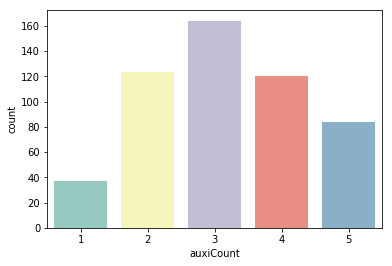

In [19]:
# Histograma del dataset filtrado

auxiCountHist = sns.countplot(x="auxiCount", data=slogansDF, palette="Set3")

In [20]:
# Distribución de los tipos de tags de las palabras auxiliares

ratioAuxiTags = dict.fromkeys(['nouns', 'verbs', 'adjs', 'other'])

c_N=0
c_V=0
c_A=0
c_O=0

# Recorrer cada auxi
for auxi in slogansDF.sloganAuxi:
    
    # Recorrer cada tag del auxi
    for elem in auxi:
        
        # Si el tag es un nombre...
        if elem.startswith('N'):
            
            # incrementa el contador y actualiza el dato de la coulmna "nouns"
            c_N += 1
            ratioAuxiTags['nouns'] = c_N
                    
        # Si el tag es un verbo...           
        if elem.startswith('V'):
            
            # incrementa el contador y actualiza el dato de la coulmna "verbs"
            c_V += 1
            ratioAuxiTags['verbs'] = c_V
        
        # Si el tag es un adjetivo...        
        if elem.startswith('J'):

            # Incrementa el contador y actualiza el dato de la coulmna "adjs"
            c_A += 1
            ratioAuxiTags['adjs'] = c_A
            
        # Si el tag es un símbolo o carcater extraño... 
        else:
            
            # Incrementa el contador y actualiza el dato de la coulmna "other"
            c_O += 1
            ratioAuxiTags['other'] = c_O

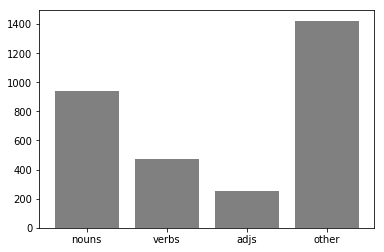

In [21]:
# Histograma categoría de tags (nombres, verbos y adjetivos) de los auxis - other (tags de simbolos y caracteres extraños)

plt.bar(ratioAuxiTags.keys(), ratioAuxiTags.values(), color='grey')

plt.show()

## KEYWORDS

### TF-IDF

In [22]:
# Fortune-500 descripciones

# Leer y generar dataset con el nombre de las compañías

#brandsF500 = pd.read_excel('brandsF500.xlsx')

# Configurar el idioma de la API de Wikipedia (inglés)

#wiki_wiki = wikipediaapi.Wikipedia('en')

# crear una lista vacía donde se irán añadiendo cada una de las descripciones

description = []

# Recorrer por filas el dtaaset

#for brand in brandsF500.brand:
      
    # Extraer el texto de cada compañía conectando con la API
    
    #description.append(wiki_wiki.page(brand).text)
    
# Crear un datframe donde cada fila contenga una descripción  

#brandsF500['brandDescription'] = description

# Volvar el resultado en un excel

#corpus_500 = brandsF500.brandDescription.to_excel('brandDescriptions500.xlsx')

In [23]:
# Extraer y añadir la descripción de la compañía de la que queremos obtener el eslogan

wiki_wiki = wikipediaapi.Wikipedia('en')

try:
    # Acceder a la página de Wikipedia de la compañía 
    
    brandWiki = wiki_wiki.page(input("Insert a brand to create a slogan from: "))
    
# En caso de que haya varias opciones, se muestran y el usuario escoge la correcta

except wiki_wiki.exceptions.DisambiguationError as e:
    
    print('\n',e.options)
    
    brandWiki = wiki_wiki.page(input("\nChoose one of the above: "))

Insert a brand to create a slogan from: Tesla


In [24]:
# Guardamos el nombre de la compañía en una variable

brandWikiTitle = brandWiki.title

# Guardamos la descripción de Wikipedia de la compañía en otra variable

brandWikiDescription = brandWiki.text

In [25]:
# Creamos el Corpus

# Cargar dataset Fortune500

corpus500 = pd.read_excel('brandDescriptions500.xlsx')

# añadimos al dataset con las descripciones de Fortune500 la descripción de la nueva compañía

corpusTot = corpus500.append(pd.DataFrame({'brandDescription': [brandWikiDescription]}))

In [26]:
# TFIDF

# Configuramos la función TfidfVectorizer (excluir stopwords, palabras alfanuméricas y que contengan alguna letra mayúscula)

tfidfVectorizer = TfidfVectorizer(stop_words = 'english', token_pattern= r'\b[^\d\W]+\b', lowercase = False)

# Aplicamos la función al corpus y guardamos el resultado en una matriz

tfidfMatrix = tfidfVectorizer.fit_transform(corpusTot['brandDescription'].values.astype('U'))

In [27]:
# Extraemos cada una de las palabras que componenen el TF-IDF --> bowT

bowT = tfidfVectorizer.get_feature_names()

print(bowT[-80:-70])

['wrongly', 'wrote', 'wrung', 'www', 'x', 'xcelenergy', 'xenon', 'xeriscape', 'xerographic', 'xerography']


In [28]:
# Convertimos la matriz TF-IDF a un array

listsTfidf = tfidfMatrix.toarray()

print(listsTfidf)

[[0.02325038 0.         0.         ... 0.         0.         0.        ]
 [0.00399731 0.         0.         ... 0.         0.         0.        ]
 [0.03018127 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.02706676 0.         0.         ... 0.         0.         0.        ]
 [0.01109421 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [29]:
# Creamos el diccionario TFIDF

# Cogemos sólo el último elemento del array (descripción de la nueva compañía)
    
listTfidf = listsTfidf[-1]

# Creamos un diccionario vacío

dictT = {}

# Recorremos cada palabra y su posición en el bowT

for index, word in enumerate(bowT):
    
    # Excluimos las palabras con una longitud menor o igual que dos y que contengan mayúsculas
    
    if len(word) > 2 and word.islower():
        
        # Añadimos al diccionario el TF-IDF asociado a cada palabra
        
        dictT[word] = listTfidf[index]

In [30]:
# Pasamos de diccionario a dataframe TF-IDF

tfidfFiltered = pd.DataFrame(dictT, index=[0])

tfidfFiltered.head()

,abandon,abandoned,abandoning,abandonment,abate,abated,abatement,abbreviated,abbreviation,abc,...,zoom,zoro,zoxamide,zuf,zus,zən,électrique,études,ʃlœ,ﬂavors
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### TF (Count Vectorizer)

In [31]:
# CountVectorizer

# Configuramos la función countVectorizer (excluir stopwords, palabras alfanuméricas y que contengan alguna letra mayúscula)

countVectorizer = CountVectorizer(stop_words = 'english', token_pattern= r'\b[^\d\W]+\b', lowercase = False)

# Aplicamos la función a la descripción de la nueva compañía y guardamos el resultado en una matriz

countMatrix = countVectorizer.fit_transform([brandWikiDescription])

In [32]:
# Extraemos cada una de las palabras que aparecen la descripción --> bowC

bowC = countVectorizer.get_feature_names()

print(bowC[-80:-70])

['Serbian', 'Superconducting', 'T', 'Teraelectronvolt', 'Tesla', 'TeslaTesla', 'They', 'US', 'Valley', 'Virginia']


In [33]:
# Convertimos la matriz CountVectorizer en un array

listCount = countMatrix.toarray()

print(listCount)

[[ 1  2  4  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  2  2  1  1  1  1  1  1  2 10  2  1  1  1  1  1
   2  1  1  1  1  1 31  1  1  3  1  1  1  1  1  1  1  1  1  2  1  1  1  1
   1  1  1  1  5  1  1  2  1  1  1  1  1  1  1  1  1  1  2  1  1  1  1  1
   1  1  1  3  1  1  3  1  1  1  2  1  1  1  1  1  2  1  1  1  1  1  1  1
   1  1  1  2  1  2  1  1  1  2]]


In [34]:
# Creamos el diccionario de CountVectorizer

# Creamos un diccionario vacío

dictC = {}

# Recorremos cada palabra y su posición en el bowC

for index, word in enumerate(bowC):
    
    # Excluimos las  palabras que tienen una longitud igual o menor que dos y contengan mayúsculas
    
    if len(word) > 2 and word.islower():
        
        # Creamos un diccionario con cada palabra y su conteo
        
        dictC[word] = listCount[0][index]

print(dict(list(dictC.items())[-20:-10]))

{'preserving': 1, 'project': 1, 'proposed': 2, 'refer': 1, 'refers': 1, 'resonant': 1, 'rock': 1, 'science': 1, 'seismically': 1, 'song': 1}


In [35]:
# Pasamos de diccionario a dataframe CountVectorizer

countFiltered = pd.DataFrame(dictC, index=[0])
countFiltered

,active,asteroid,automotive,band,beginning,brand,cards,circuit,coal,coil,...,space,state,symbol,technology,things,titles,town,transformer,type,unit
0,1,1,1,2,1,1,1,1,1,1,...,1,1,1,2,1,2,1,1,1,2


### Wordcloud

In [36]:
# Lemmatizamos la bowT para la visualización de la WordCloud

# Creamo un diccionario vacío

dictTLemma = {}

# Creamos una lista vacía

keysLemma = []

# Recorremos cada key del diccionario TF-IDF

for key in dictT:
    
    # Lematizamos la palabra
    
    keyLemma = nltk.stem.WordNetLemmatizer().lemmatize(key)

    # Si la palabra lematizada no está contenida en la lista de keysLemma, la añadimos
    
    if keyLemma not in keysLemma:
        
        # Añadimos la palabra y el resultado del TF-IDF al diccionario vacío TF-IDF_lemmas
        
        dictTLemma[keyLemma] = dictT[key]
        
        # Añadimos la palabra a la lista de palabras lematizadas
        
        keysLemma.append(keyLemma)
    
    # Si la palabra ya existe en la lista de palabras lemmatizadas, adicionamos su valor de TF-IDF a la key correspondiente
    
    else: 
        
        dictTLemma[keyLemma] += dictT[key]
    

In [ ]:
# Wordcloud

# Configuramos la función (excluimos las stopwords, determinamos el color y tamaño de la imagen) y la aplicamos al diccionario creado con Tf-IDF de los lemas

wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', width=3500,height=3000).fit_words(dictTLemma)

# Visualizamos el resultado

plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Extracción de Keywords

In [40]:
# Retomamos el diccionario original y ordenamos las palabras de mayor a menor TF-IDF

topWords = Counter(dictT).most_common()

### Filtrado - Tags

In [41]:
# Analizamos morfológicamente las palabras del diccionario TF-IDF

# Aplicamos la función pos_tag a cada palabra (no seleccionamos el valor del TF-IDF) y guardamos el resultado en una lista

topWordsTagged = nltk.pos_tag(((np.asarray(topWords))[:,0]))

print(topWordsTagged[0:10])

[('microarchitecture', 'NN'), ('crater', 'NN'), ('band', 'NN'), ('titles', 'NNS'), ('pages', 'NNS'), ('film', 'NN'), ('collider', 'NN'), ('flux', 'VB'), ('honour', 'JJ'), ('particle', 'NN')]


In [42]:
# Filtramos por tag (seleccionamos sólo los nombres, verbos y adjetivos)

# Creamos una lista vacía

topWordsFiltered = []

# Recorremos cada elemento de la lista topWordsTagged

for pair in topWordsTagged:
    
    # Cremaos una lista vacía por cada elemento
    
    skeleton = []
    
    # Si el tag de la topword es un nombre, verbo o adjetivo
    
    if pair[1] not in pos_in:
        
        # Conservamos la palabra (auxiliar)
        
        topWordsFiltered.append(pair)

print(topWordsFiltered[0:10])

[('microarchitecture', 'NN'), ('crater', 'NN'), ('band', 'NN'), ('titles', 'NNS'), ('pages', 'NNS'), ('film', 'NN'), ('collider', 'NN'), ('flux', 'VB'), ('honour', 'JJ'), ('particle', 'NN')]


In [43]:
len(topWordsFiltered)

17272

### Filtrado - Análisis de sentimiento

In [44]:
# Análisis de sentimiento de las topWords seleccionadas

# Creamos un diccionario vacío para rellenar con las topWords y su score de snetimiento negativo

sentiments = {}


# Recorremos cada elemento de la lista topWordsFiltered

for couple in topWordsFiltered:
    
    
    # Acoplamos las palabras a los diferentes casos posibles de análisis de sentiWordNet 
    
    try:
        
        # Añadimos '.n' y .01 para analizarla como sustantivo y primera acepción del término
        
        senti = swn.senti_synset(couple[0] + '.n' +'.01')
        
        # Obtenemos el score del sentimiento negativo 
        
        sentiments[couple[0]] = senti.neg_score()
        
    except:
        
        
        try:
            
            # Añadimos '.v' y .01 para analizarla como verbo y primera acepción del término
                
            senti = swn.senti_synset(couple[0] + '.v' +'.01')
            
            # Obtenemos el score del sentimiento negativo 
            
            sentiments[couple[0]] = senti.neg_score() 

        except:
            
            
            try:
                
                # Añadimos '.a' y .01 para analizarla como adjetivo y primera acepción del término
            
                senti = swn.senti_synset(couple[0] + '.a' +'.01')
                
                # Obtenemos el score del sentimiento negativo 
                    
                sentiments[couple[0]] = senti.neg_score() 
                

            except:
                
                try:
                    
                    # Añadimos '.n' y .01 para analizarla como adjetivo satélite y primera acepción del término
                    
                    senti = swn.senti_synset(couple[0] + '.s' +'.01')
                    
                    # Obtenemos el score del sentimiento negativo 
                    
                    sentiments[couple[0]] = senti.neg_score() 

                except:
             
                    try:
                        
                        # Añadimos '.r' y .01 para analizarla como adjetivo y primera acepción del término
            
                        senti = swn.senti_synset(couple[0] + '.r' +'.01')
                
                        # Obtenemos el score del sentimiento negativo 
                
                        sentiments[couple[0]] = senti.neg_score()
            
                    except:
                    
                        continue
                        
list(sentiments.items())[0:10]

[('crater', 0.0),
 ('band', 0.0),
 ('film', 0.0),
 ('collider', 0.0),
 ('flux', 0.0),
 ('honour', 0.0),
 ('particle', 0.0),
 ('lunar', 0.0),
 ('opera', 0.0),
 ('resonant', 0.125)]

In [45]:
# Eliminamos las keywords que tienen score negativo mayor que cero

# Recorremos cada elemento del diccionario de análisis de sentimiento negativo

for index, (word, senti) in enumerate(sentiments.items()):
    
    # Si el sentimiento mnegativo es mayor que 0
    
    if senti > 0:
        
        # Recorremos cada elemento de topWordsFiltered
        
        for couple in topWordsFiltered:
            
            # Si la palabra con el score negativo es igual a la topWord
            
            if couple[0] == word:
                
                # Eliminamos la topWord 
                
                topWordsFiltered.remove(couple)

In [46]:
len(topWordsFiltered)

15423

### Cantidad mínima

In [47]:
# Determinar el máximo necesario de tags de cada tipo para poder compeltar todos los esqueletos

# Creamos una lista con los tags de los auxis

tag_auxi = ["NN", "NNS", "NNP", "NNPS", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ", "JJ", "JJR", "JJS"]

# Creamos un dataframe vacío con columnas nombradas como la lista de tags anterior

df_auxi = pd.DataFrame(columns = tag_auxi)

# Recorremos cada auxi

for row in slogansDF.sloganAuxi:
    
    # Recorremos cada elemento del auxi, hacemos su conteo y lo guardamos en un diccionario
    
    drow = dict((x, row.count(x)) for x in tag_auxi)
       
    # Añadimos el resultado al dataframe inicial
    
    df_auxi = df_auxi.append(drow , ignore_index=True)

# Concatenamos el nuevo dataframe al inicial 

slogansDF = pd.concat([slogansDF, df_auxi], axis=1)

# Eliminamos columnas generadas tras el procesamiento que no interesan

slogansDF = slogansDF.drop(["level_0", "index"], axis = 1)

slogansDF.head()

,slogans,sloganTagged,sloganSkeleton,sloganAuxi,auxiCount,NN,NNS,NNP,NNPS,VB,VBD,VBG,VBN,VBP,VBZ,JJ,JJR,JJS
0,A-1 makes hamburgers taste like steakburgers,"[(a-1, JJ), (makes, VBZ), (hamburgers, NNS), (taste, VBP), (like, IN), (steakburgers, NNS)]","[JJ, VBZ, NNS, VBP, like, NNS]","[JJ, VBZ, NNS, VBP, NNS]",5,0,2,0,0,0,0,0,0,1,1,1,0,0
1,Get the Abbey habit,"[(get, VB), (the, DT), (abbey, NN), (habit, NN)]","[VB, the, NN, NN]","[VB, NN, NN]",3,2,0,0,0,1,0,0,0,0,0,0,0,0
2,Because life’s complicated enough,"[(because, IN), (life, NN), (’, NNP), (s, NN), (complicated, VBD), (enough, RB)]","[because, NN, NNP, NN, VBD, enough]","[NN, NNP, NN, VBD]",4,2,0,1,0,0,1,0,0,0,0,0,0,0
3,Access takes the waiting out of wanting,"[(access, NN), (takes, VBZ), (the, DT), (waiting, VBG), (out, IN), (of, IN), (wanting, VBG)]","[NN, VBZ, the, VBG, out, of, VBG]","[NN, VBZ, VBG, VBG]",4,1,0,0,0,0,0,2,0,0,1,0,0,0
4,Makes sensible buying simple,"[(makes, VBZ), (sensible, JJ), (buying, NN), (simple, NN)]","[VBZ, JJ, NN, NN]","[VBZ, JJ, NN, NN]",4,2,0,0,0,0,0,0,0,0,1,1,0,0


In [48]:
# Obtener la cantidad mínima de keywords necesaria para poder completar el total de esqueletos generados (sumar los máximos del conteo de cada tag)

totalKeywords = (slogansDF.NN.max()) + (slogansDF.NNS.max()) + (slogansDF.NNP.max()) + (slogansDF.NNPS.max()) + (slogansDF.VB.max()) + (slogansDF.VBD.max()) + (slogansDF.VBG.max()) + (slogansDF.VBN.max()) + (slogansDF.VBP.max()) + (slogansDF.VBZ.max()) + (slogansDF.JJ.max()) + (slogansDF.JJR.max()) + (slogansDF.JJS.max())

In [49]:
totalKeywords

27

In [50]:
# Extracción de keywords finales (topWords)

# Creamos una lista vacía

topWordsFinal = []

# Innicializamos variables

count = 0

n = 0
ns = 0
np = 0
nps = 0
vb = 0
vbd = 0
vbg = 0
vbn = 0
vbp = 0
vbz = 0
jj = 0
jjr = 0
jjs = 0

# Recorremos cada elemento de TopWordsFiltered y su posición

for index, word in enumerate(topWordsFiltered):
    
    # Si el tag de la palabra es "NN" y todavía no tenemos todas las "NN" necesarias, seleccionamos las topWord (idem para cada caso)
    
    if word[1] == "NN" and n<max(slogansDF.NN):
        
        # Incrementamos en 1 el contador de los sutantivos
        n += 1
        
        # Añadimos a la lista la keyword y su posición (c)
        
        topWordsFinal.append([word, index])

    elif word[1] == "NNS" and ns<max(slogansDF.NNS):

        ns += 1
        topWordsFinal.append([word, index])

    elif word[1] == "NNP" and np<max(slogansDF.NNP):

        np += 1 
        topWordsFinal.append([word, index])

    elif word[1] == "NNPS" and nps<max(slogansDF.NNPS):

        nps += 1
        topWordsFinal.append([word, index])

    elif word[1] == "VB" and vb<max(slogansDF.VB):

        vb += 1
        topWordsFinal.append([word, index])

    elif word[1] == "VBD" and vbd<max(slogansDF.VBD):

        vbd += 1
        topWordsFinal.append([word, index])

    elif word[1] == "VBG" and vbg<max(slogansDF.VBG):

        vbg += 1
        topWordsFinal.append([word, index])

    elif word[1] == "VBN" and vbn<max(slogansDF.VBN):

        vbn += 1
        topWordsFinal.append([word, index])

    elif word[1] == "VBP" and vbp<max(slogansDF.VBP):

        vbp += 1
        topWordsFinal.append([word, index])

    elif word[1] == "VBZ" and vbz<max(slogansDF.VBZ):

        vbz += 1
        topWordsFinal.append([word, index])

    elif word[1] == "JJ" and jj<max(slogansDF.JJ):

        jj += 1
        topWordsFinal.append([word, index])

    elif word[1] == "JJR" and jjr<max(slogansDF.JJR):

        jjr += 1
        topWordsFinal.append([word, index])

    elif word[1] == "JJS" and jjs<max(slogansDF.JJS):

        jjs += 1
        topWordsFinal.append([word, index])

    elif count == totalKeywords:
        
        break
    
    # Cuenta el total de topWords seleccionadas
    
    count = n + ns + np + nps + vb + vbd + vbg + vbn + vbp + vbz + jj + jjr + jjs
    
    # Guardamos la posición de la última keyword
    
    pos_max = index

In [51]:
# Cantidad de keywords escogidas

count

27

In [52]:
# Cantidad de keywords recorridas

pos_max

7531

In [53]:
topWordsFinal

[[('microarchitecture', 'NN'), 0],
 [('crater', 'NN'), 1],
 [('band', 'NN'), 2],
 [('titles', 'NNS'), 3],
 [('pages', 'NNS'), 4],
 [('film', 'NN'), 5],
 [('flux', 'VB'), 7],
 [('honour', 'JJ'), 8],
 [('preserving', 'VBG'), 10],
 [('lunar', 'JJ'), 11],
 [('asteroid', 'JJ'), 13],
 [('proposed', 'VBD'), 15],
 [('named', 'VBD'), 21],
 [('refers', 'NNS'), 22],
 [('rock', 'VBP'), 23],
 [('abandoning', 'VBG'), 61],
 [('abbreviated', 'VBN'), 65],
 [('abnormality', 'VBP'), 77],
 [('abscesses', 'VBZ'), 87],
 [('accelerates', 'VBZ'), 112],
 [('accelerometer', 'VBP'), 117],
 [('accidents', 'VBZ'), 129],
 [('acquire', 'VB'), 193],
 [('adopt', 'VB'), 308],
 [('amplifier', 'JJR'), 595],
 [('behest', 'JJS'), 1349],
 [('keyfobs', 'NNP'), 7531]]

# Generación de Eslóganes

### Word Embedding - Gensim

In [54]:
# Modelo pre-entrenado de wordEmbedding

# Generamos el modelo pre-entrenado de word2vec con el fichero de GoogleNews

#model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# Guardamos el modelo

#pickle.dump(model, open("gensimModel", 'wb'))

In [55]:
# Cargamos el modelo pre-entrenado de wordEmbedding

gensimModel = pickle.load(open("gensimModel", 'rb'))

In [56]:
# Creamos la función de similitud entre palabras 

# El input de la función son dos palabras

def word_embedding (wd1, wd2):
    
    # Si alguna de las palabras no está contenida en el modelo
    
    if (wd1 not in gensimModel.vocab) or (wd2 not in gensimModel.vocab):
        
        # Se establecerá la menor similitud
        
        sim = -1
        
    # Si ambas palabras están contenidas en el modelo
    
    else:
        
        # Calculamos el grado de similitud entre palabras
        
        sim = gensimModel.similarity(wd1, wd2)
        
        # Si las palabras son idénticas, le aplicamos la menor similitud (no plagio de eslóganes!!!)
        
        if sim >= 0.9:
            
            sim = -1
            
    # La función devuelve el ratio de similitud
    
    return sim


### Selección de keywords

In [57]:
slogansDF.head()

,slogans,sloganTagged,sloganSkeleton,sloganAuxi,auxiCount,NN,NNS,NNP,NNPS,VB,VBD,VBG,VBN,VBP,VBZ,JJ,JJR,JJS
0,A-1 makes hamburgers taste like steakburgers,"[(a-1, JJ), (makes, VBZ), (hamburgers, NNS), (taste, VBP), (like, IN), (steakburgers, NNS)]","[JJ, VBZ, NNS, VBP, like, NNS]","[JJ, VBZ, NNS, VBP, NNS]",5,0,2,0,0,0,0,0,0,1,1,1,0,0
1,Get the Abbey habit,"[(get, VB), (the, DT), (abbey, NN), (habit, NN)]","[VB, the, NN, NN]","[VB, NN, NN]",3,2,0,0,0,1,0,0,0,0,0,0,0,0
2,Because life’s complicated enough,"[(because, IN), (life, NN), (’, NNP), (s, NN), (complicated, VBD), (enough, RB)]","[because, NN, NNP, NN, VBD, enough]","[NN, NNP, NN, VBD]",4,2,0,1,0,0,1,0,0,0,0,0,0,0
3,Access takes the waiting out of wanting,"[(access, NN), (takes, VBZ), (the, DT), (waiting, VBG), (out, IN), (of, IN), (wanting, VBG)]","[NN, VBZ, the, VBG, out, of, VBG]","[NN, VBZ, VBG, VBG]",4,1,0,0,0,0,0,2,0,0,1,0,0,0
4,Makes sensible buying simple,"[(makes, VBZ), (sensible, JJ), (buying, NN), (simple, NN)]","[VBZ, JJ, NN, NN]","[VBZ, JJ, NN, NN]",4,2,0,0,0,0,0,0,0,0,1,1,0,0


In [58]:
# Creamos una función que seleccione la palabra con mayor score de entre todas las topWords posibles

# El input de la función es (palabra,tag) del eslogan original y (palabra,tag) de las topWords

def max_score (ori_tuple, kws):
    
    # Guardamos la palabra del eslogan original
    
    ori_word = ori_tuple[0]
    
    # Guardamos el tag de la palabra del eslogan original
    
    ori_tag = ori_tuple[1]
    
    # inicializamos la variable winner y el score
    
    winner = 'hola'
    
    sc_best = -1
    
    # Recorremos todos los elementos de las topWords
    
    for elem in kws:
        
        # Si el tag de la keyword y de la palabra original del eslogan coinciden
        
        if elem[0][1] == ori_tag:
            
            # Calculamos la similitud entre ellas
            
            sim = word_embedding(ori_word, elem[0][0])
            
            # Normzaliamos la posición de la topWord
            
            kw_sc = (pos_max - elem[1])/pos_max
            
            # Aplicamos la función del score(sim + pos_normalizada)
            
            sc = kw_sc + sim
            
            # Si el score es mayor que sc_best
            
            if sc >= sc_best:
                
                # Actualizamos el valor de sc_best por el nuevo score
                
                sc_best = sc
                
                # Actualizamos la variable winner con ((topWord,tag), pos)
                
                winner = elem
                
    # Borramos de las topWords el elemento seleccionado para evitar usar la misma palabra en un mismo eslogan
    
    kws.remove(winner)
    
    
    # La función devuelve el elemento de topWords ganador, la lista de topWords sin el elemento winner y el score
    
    return winner, kws, sc_best

### Algoritmo

In [59]:
# Algoritmo Generación Eslogan

# Creamos dos listas vacías

slogansDone = []
scoresDone = []

# Recorremos cada sloganTagged

for elem in slogansDF.sloganTagged:
    
    # Inicializamos variables
    
    norm = 0
    
    slogan = []
    
    score = 0
    
    # Realizamos una copia de las topWords
    
    kws = topWordsFinal.copy()
    
    # Recorremos cada elemento de cada sloganTagged
    
    for elem2 in elem:
        
        # Si el tag de la palabra es un nombre, verbo o adjetivo
        
        if elem2[1] in tag_auxi:
            
            # Incrementamos la variable norm en 1
            
            norm += 1
            
            # Aplicamos la función de max_score y guardamoms el resultados en tres variables
            
            chosen, kws, sc_score = max_score (elem2, kws)
            
            # Añadimos a la varibale slogan la topWord ganadora 
            
            slogan.append(chosen[0][0])
            
            # Adicionamos a la variable score, el score de todas las topWords que van formando el eslogan
        
            score += sc_score
            
        # Si el tag de la palabra no es un nombre, verbo o adjetivo   
        
        else:
            
            # Añadimos a la variable slogan la palabra del sloganTagged
            
            slogan.append(elem2[0])
            
    # Inicializamos la variable s a un espacio por cada slogan    
    s = ' '
    
    # Añadimos cada eslogan generado con un espacio entre ellos
    
    slogansDone.append(s.join(slogan))
    
    # Añadimos a la lista scoresDone el score de cada eslogan generado normalziado por el número de topWords empleadas
    
    scoresDone.append(score/norm)

In [60]:
# Creamos un dataframe con todos los eslóganes generados y su score

df_auxi2 = pd.DataFrame({'slogansGen': slogansDone, 'score': scoresDone})

# Concatenamos este dataframe al inicial

slogansDF = pd.concat([slogansDF, df_auxi2], axis=1)

slogansDF.head()

,slogans,sloganTagged,sloganSkeleton,sloganAuxi,auxiCount,NN,NNS,NNP,NNPS,VB,VBD,VBG,VBN,VBP,VBZ,JJ,JJR,JJS,slogansGen,score
0,A-1 makes hamburgers taste like steakburgers,"[(a-1, JJ), (makes, VBZ), (hamburgers, NNS), (taste, VBP), (like, IN), (steakburgers, NNS)]","[JJ, VBZ, NNS, VBP, like, NNS]","[JJ, VBZ, NNS, VBP, NNS]",5,0,2,0,0,0,0,0,0,1,1,1,0,0,honour accelerates pages abnormality like titles,0.923054
1,Get the Abbey habit,"[(get, VB), (the, DT), (abbey, NN), (habit, NN)]","[VB, the, NN, NN]","[VB, NN, NN]",3,2,0,0,0,1,0,0,0,0,0,0,0,0,acquire the crater film,1.139244
2,Because life’s complicated enough,"[(because, IN), (life, NN), (’, NNP), (s, NN), (complicated, VBD), (enough, RB)]","[because, NN, NNP, NN, VBD, enough]","[NN, NNP, NN, VBD]",4,2,0,1,0,0,1,0,0,0,0,0,0,0,because film keyfobs crater proposed enough,0.587580
3,Access takes the waiting out of wanting,"[(access, NN), (takes, VBZ), (the, DT), (waiting, VBG), (out, IN), (of, IN), (wanting, VBG)]","[NN, VBZ, the, VBG, out, of, VBG]","[NN, VBZ, VBG, VBG]",4,1,0,0,0,0,0,2,0,0,1,0,0,0,microarchitecture accelerates the abandoning out of preserving,1.167139
4,Makes sensible buying simple,"[(makes, VBZ), (sensible, JJ), (buying, NN), (simple, NN)]","[VBZ, JJ, NN, NN]","[VBZ, JJ, NN, NN]",4,2,0,0,0,0,0,0,0,0,1,1,0,0,accelerates asteroid band microarchitecture,1.142807


### Solución

In [61]:
# Ordenamos el dataframe en sentido descendente por el valor de la columna score

slogansSorted = slogansDF.sort_values(by=['score'], ascending=False)

slogansSorted.head()

,slogans,sloganTagged,sloganSkeleton,sloganAuxi,auxiCount,NN,NNS,NNP,NNPS,VB,VBD,VBG,VBN,VBP,VBZ,JJ,JJR,JJS,slogansGen,score
159,It never varies,"[(it, PRP), (never, RB), (varies, NNS)]","[it, never, NNS]",[NNS],1,0,1,0,0,0,0,0,0,0,0,0,0,0,it never refers,1.390894
507,Stop me and buy one,"[(stop, VB), (me, PRP), (and, CC), (buy, VB), (one, CD)]","[VB, me, and, VB, one]","[VB, VB]",2,0,0,0,0,2,0,0,0,0,0,0,0,0,adopt me and acquire one,1.362049
513,Breakfast of Champions,"[(breakfast, NN), (of, IN), (champions, NNS)]","[NN, of, NNS]","[NN, NNS]",2,1,1,0,0,0,0,0,0,0,0,0,0,0,crater of titles,1.264684
233,Harp puts out the fire,"[(harp, NN), (puts, VBZ), (out, RP), (the, DT), (fire, NN)]","[NN, VBZ, out, the, NN]","[NN, VBZ, NN]",3,2,0,0,0,0,0,0,0,0,1,0,0,0,band accelerates out the crater,1.263838
367,It helps protect your skin.,"[(it, PRP), (helps, VBZ), (protect, VB), (your, PRP$), (skin, NN), (., .)]","[it, VBZ, VB, your, NN, .]","[VBZ, VB, NN]",3,1,0,0,0,1,0,0,0,0,1,0,0,0,it accelerates adopt your microarchitecture .,1.253401


In [62]:
# Escogemos la columna del eslogan generado con el mayor score

sloganGenerated = slogansSorted.iloc[0,18]

# Ponemos en mayúscula la primera letra y quitamos espacios al inicio o final no deseados

sloganGenerated = sloganGenerated.capitalize().strip()

In [63]:
sloganGenerated

'It never refers'

# Encuesta

In [ ]:
# Obtenemos las listas de eslóganes de percentil 0.25, 0.5 and 0.75 y seleccionamos el último en cada caso

sloganQ1 = slogansSorted[slogansSorted['score'] <= slogansSorted['score'].quantile(0.25)].iloc[-1,18]

sloganQ2 = slogansSorted[(slogansSorted['score'] > slogansSorted['score'].quantile(0.25)) & (slogansSorted['score'] < slogansSorted['score'].quantile(0.75))].iloc[-1,18]

sloganQ3 = slogansSorted[slogansSorted['score'] >= slogansSorted['score'].quantile(0.75)].iloc[-1,18]

In [ ]:
# Lista con el eslogan ganador y los tres eslóganes seleccionados de cada percentil

slogansSelected = [sloganGenerated, sloganQ3, sloganQ2, sloganQ1]

brand = brandWikiTitle

In [ ]:
slogansSelected

In [ ]:
# Dataframe con la lista de eslóganes y el nombre de la primera compañía 

slogansPoll = pd.DataFrame({"brand": brand, "slogans": slogansSelected})

slogansPoll

# Exportar el resultado a un documento excel

slogansPoll.to_excel('slogansPoll.xlsx')

In [ ]:
# Crear dataframe con los cuatro eslóganes seleccionados y la compañía (a partir de la segunda compañía)

#slogansPollRe = pd.DataFrame({"brand": brand, "slogans": slogansSelected})

# Concatenear el resultado de las 10 compañías en el dataframe

#slogansPoll = slogansPoll.append(slogansPollRe, ignore_index = True)

# Abrir y guardar en el excel (hasta tener las 10 compañias para la encuesta)

#slogansPoll = pd.read_excel('slogansPoll.xlsx')

#slogansPoll.to_excel('slogansPoll.xlsx')